In [94]:
import pandas as pd
import numpy as np
from plotnine import *
import matplotlib.pyplot as plt
import glob

In [76]:
fve_0_1_df = pd.read_parquet("multi_model_1000_0.99_10000_100_RMSE_0.95_600_1/results.parquet")
fve_0_1_df

,hyper_idx,h,observed,prediction,lower_bound,upper_bound,coverage_flags,squared_error,pred_length,flops,num_params,sd,runtime
0,0,1,-0.796976,-0.201219,-3.677913,3.275477,True,0.354926,6.953390,59.24,12.20,10.512966,PatchTST
1,0,2,-1.682299,-0.391785,-4.333045,3.549476,True,1.665425,7.882522,59.24,12.20,10.512966,PatchTST
2,0,3,-1.186190,0.172402,-3.037760,3.382566,True,1.845774,6.420326,59.24,12.20,10.512966,PatchTST
3,0,4,-0.501875,-0.239789,-4.233179,3.753603,True,0.068689,7.986782,59.24,12.20,10.512966,PatchTST
4,0,5,-1.333600,-0.262915,-4.595744,4.069917,True,1.146367,8.665661,59.24,12.20,10.512966,PatchTST
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9999995,999,96,-13.896681,-0.543654,-18.798592,17.711292,True,178.303326,36.509884,357.30,111.65,10.512966,PatchTST
9999996,999,97,-13.817044,-0.144286,-18.699293,18.410727,True,186.944304,37.110020,357.30,111.65,10.512966,PatchTST
9999997,999,98,-13.717976,-0.002160,-17.365631,17.361317,True,188.123617,34.726948,357.30,111.65,10.512966,PatchTST
9999998,999,99,-12.787908,0.016784,-19.144501,19.178080,True,163.960155,38.322578,357.30,111.65,10.512966,PatchTST


In [78]:
def find_pareto_front_hyperidx(x:np.ndarray, y:np.ndarray):
    paretof_hyper_idxs = []
    i = np.argmin(y)
    paretof_hyper_idxs.append(i)
    while np.any(x < x[i]):
        idx = np.argwhere(x < x[i])
        i0 = np.argmin(y[idx])
        i = idx[i0][0]
        paretof_hyper_idxs.append(i)
    x_boundary = np.array(x[paretof_hyper_idxs]) 
    y_boundary = np.array(y[paretof_hyper_idxs]);

    x_enhanced_boundary = np.array(x[paretof_hyper_idxs])
    y_enhanced_boundary = np.array(y[paretof_hyper_idxs]);
    
    n_b = x_boundary.size
    x_boundary = np.insert(x_boundary,[0,n_b],[np.max(x),np.min(x)]);
    y_boundary = np.insert(y_boundary,[0,n_b],[np.min(y),np.max(y)]);
    
    n_eb = x_enhanced_boundary.size
    idx = np.arange(0,(n_eb-1))
    x_enhanced_boundary = np.insert(x_enhanced_boundary,idx+1,x_enhanced_boundary[idx])
    y_enhanced_boundary = np.insert(y_enhanced_boundary,idx+1,y_enhanced_boundary[idx+1])
    n_eb = x_enhanced_boundary.size
    x_enhanced_boundary = np.insert(x_enhanced_boundary,[0,n_eb],[np.max(x),np.min(x)]);
    y_enhanced_boundary = np.insert(y_enhanced_boundary,[0,n_eb],[np.min(y),np.max(y)]);
   
    
    return paretof_hyper_idxs, x_boundary, y_boundary, x_enhanced_boundary, y_enhanced_boundary 

In [115]:
def make_pareto_frontier_plot(results: pd.DataFrame, h: list[int], metric: str, title: str, alpha = 1,
                              log_scale: bool=False, add_oracle_NRMSE_line: bool=False, fve: float=np.nan) -> tuple[ggplot, list[int]]:
    results = results[results["h"].isin(h)].copy()

    results = results.groupby(["hyper_idx"]).agg(
        mean_squared_error=("squared_error", "mean"),
        RMSE=("squared_error", lambda x: np.sqrt(x.mean())),
        coverage_accuracy=("coverage_flags", "mean"),
        flops = ("flops", "mean"),
        num_params = ("num_params", "mean"),
        sd = ("sd", "mean")
    )

    results["normalized_rmse"] = results["RMSE"] / results["sd"]
    if metric == "flops":
        xlab = "Flops (K)"
    else:
        xlab = "Number of Parameters (K)"

    results.reset_index(drop=False, inplace=True)
    pareto_hyper_idx, x_b, y_b, x_eb, y_eb= find_pareto_front_hyperidx(results[metric].values, results["normalized_rmse"].values)
    results["boundary_flags"] = results["hyper_idx"].isin(pareto_hyper_idx)
    
    boundary_df = pd.DataFrame({metric: x_b, "normalized_rmse": y_b})
    enhanced_boundary_df = pd.DataFrame({metric: x_eb[:-1], "normalized_rmse": y_eb[:-1],
                                         "metric_end": x_eb[1:], "normalized_rmse_end": y_eb[1:]})

    plot = (
        ggplot(results, aes(x = metric, y = "normalized_rmse")) +
        geom_point(alpha = alpha) +
        geom_point(results[results["boundary_flags"]], color = "blue", size = 2) + 
        geom_segment(aes(x = metric, y = "normalized_rmse", xend = "metric_end", yend = "normalized_rmse_end"),
                     data = enhanced_boundary_df, color = "red") +
        # geom_line(boundary_df, aes(x = metric, y = "normalized_rmse"), color = "red") + 
        # geom_line(enhanced_boundary_df, aes(x = metric, y = "normalized_rmse"), color = "blue") +
        labs(x = xlab, y = "Normalized RMSE", title=title) +
        theme_bw()
    )

    # plt.plot(results[metric], results["normalized_rmse"],".", alpha = alpha)
    # plt.plot(x_b,y_b,"r")
    # plt.plot(x_eb,y_eb,"b")
    # plt.xlabel(xlab)
    # plt.ylabel("Normalized RMSE")
    # plt.title(title)
    #plt.show()

    if log_scale:
        plot = plot + scale_x_log10()

    if add_oracle_NRMSE_line:
        plot = plot + geom_hline(yintercept = np.sqrt(1-fve**min(h)), linetype = "dashed")
    boundary_idx = []

    return plot, boundary_idx

In [124]:
title = "AR(1), FVE=0.99, h=10"
plot, _= make_pareto_frontier_plot(fve_0_1_df, list([10]), "flops", title, 0.3, False, True, 0.99)
plot

arima_df = pd.read_parquet("ARIMA_model_1_0.99_10000_100_RMSE_0.95_600_1/results.parquet")


arima_df = arima_df[arima_df["h"].isin(([50]))].copy()
arima_df = arima_df.groupby("hyper_idx").agg(
    mean_squared_error=("squared_error", "mean"),
    RMSE=("squared_error", lambda x: np.sqrt(x.mean())),
    sd = ("sd", "mean")
)
print(arima_df)
arima_df["normalized_rmse"] = arima_df["RMSE"] / arima_df["sd"]
arima_df

           mean_squared_error      RMSE         sd
hyper_idx                                         
0                   48.033611  6.930628  10.512966


,mean_squared_error,RMSE,sd,normalized_rmse
hyper_idx,,,,
0,48.033611,6.930628,10.512966,0.659246


c:\ProgramData\anaconda3\envs\autogluon_env\Lib\site-packages\IPython\lib\pretty.py:794: FutureWarning: Using repr(plot) to draw and show the plot figure is deprecated and will be removed in a future version. Use plot.show().


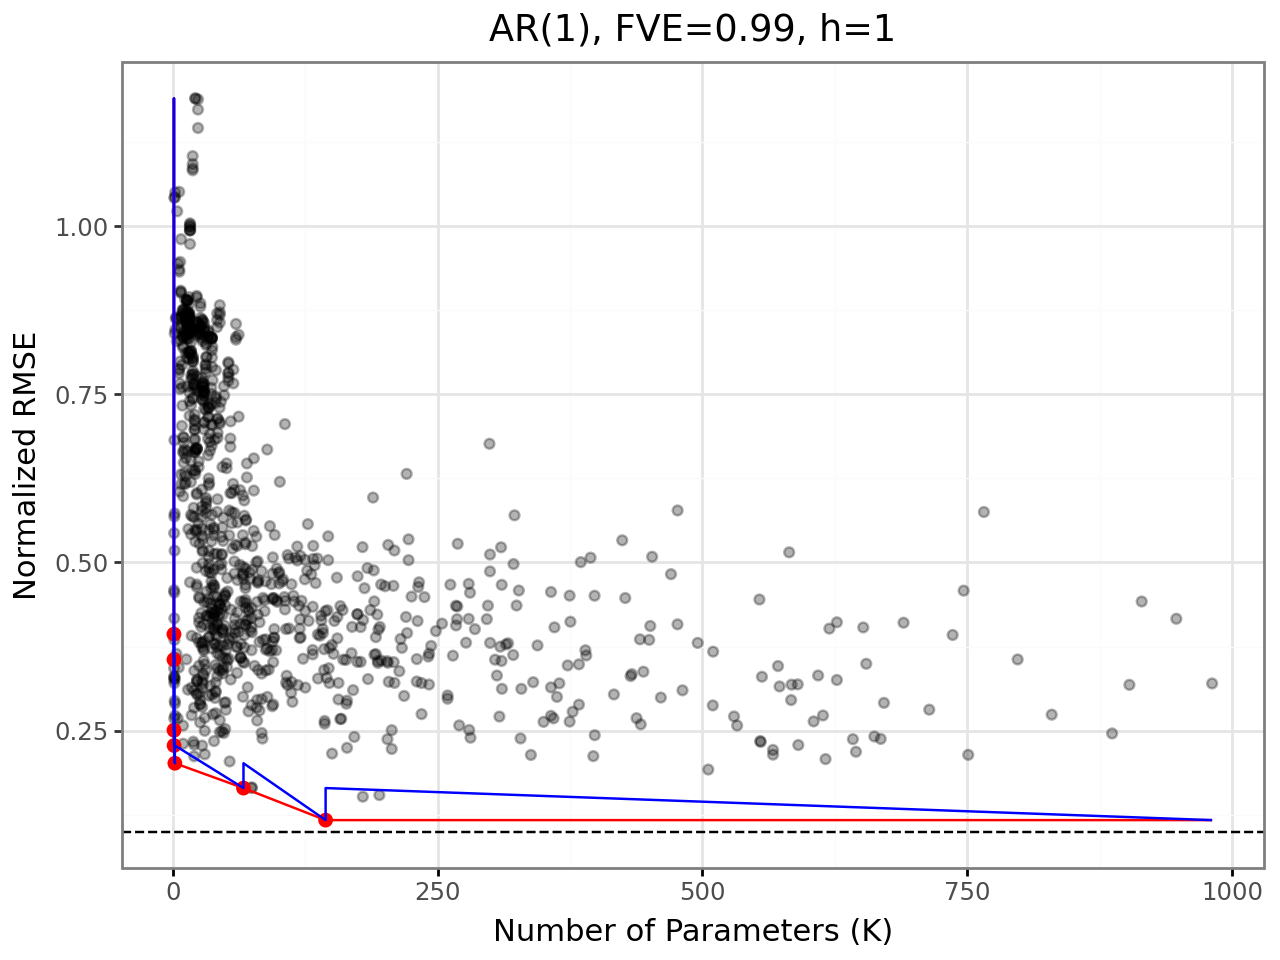

c:\ProgramData\anaconda3\envs\autogluon_env\Lib\site-packages\IPython\lib\pretty.py:794: FutureWarning: Using repr(plot) to draw and show the plot figure is deprecated and will be removed in a future version. Use plot.show().


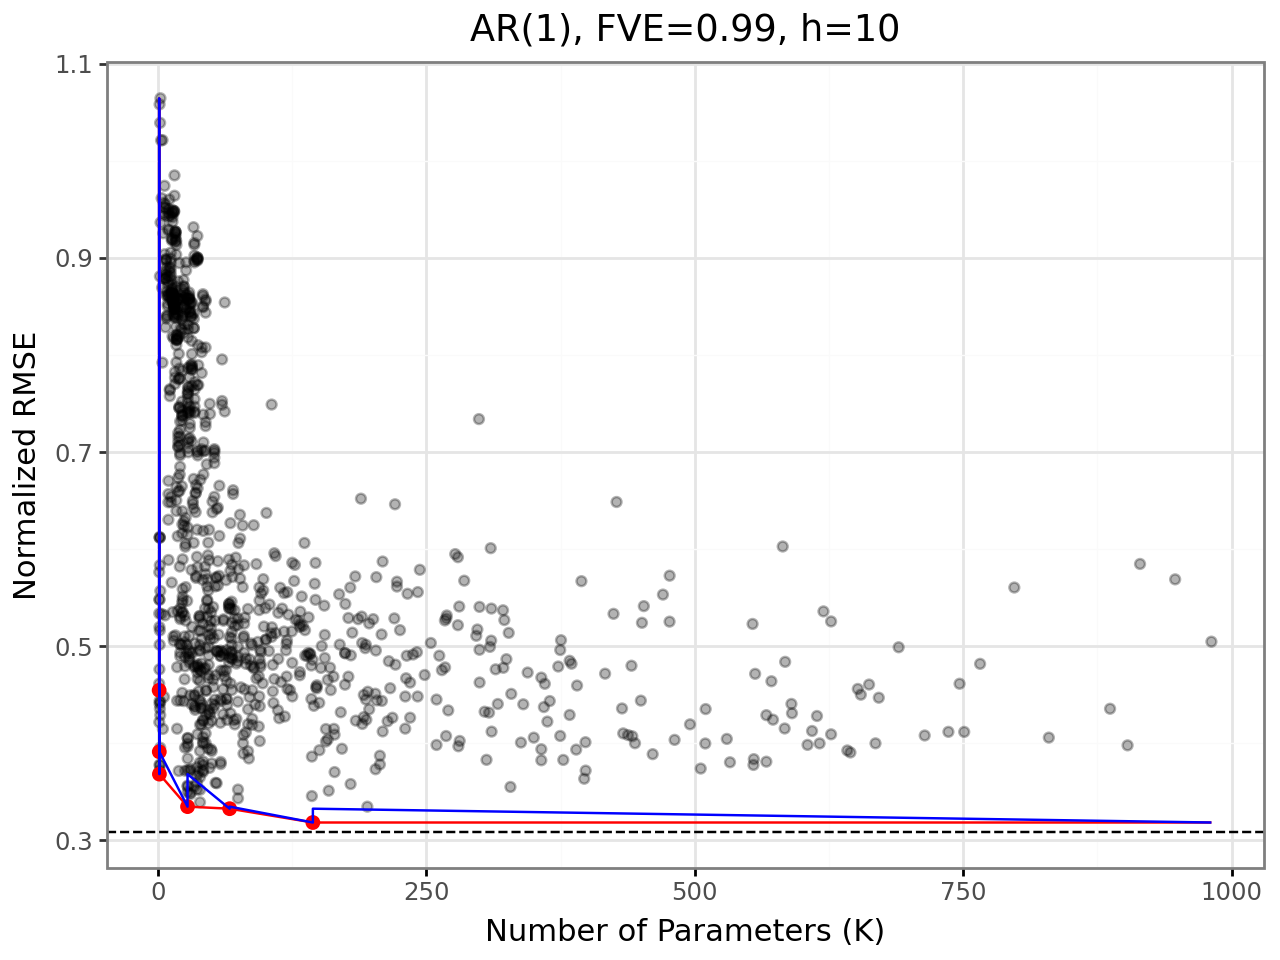

c:\ProgramData\anaconda3\envs\autogluon_env\Lib\site-packages\IPython\lib\pretty.py:794: FutureWarning: Using repr(plot) to draw and show the plot figure is deprecated and will be removed in a future version. Use plot.show().


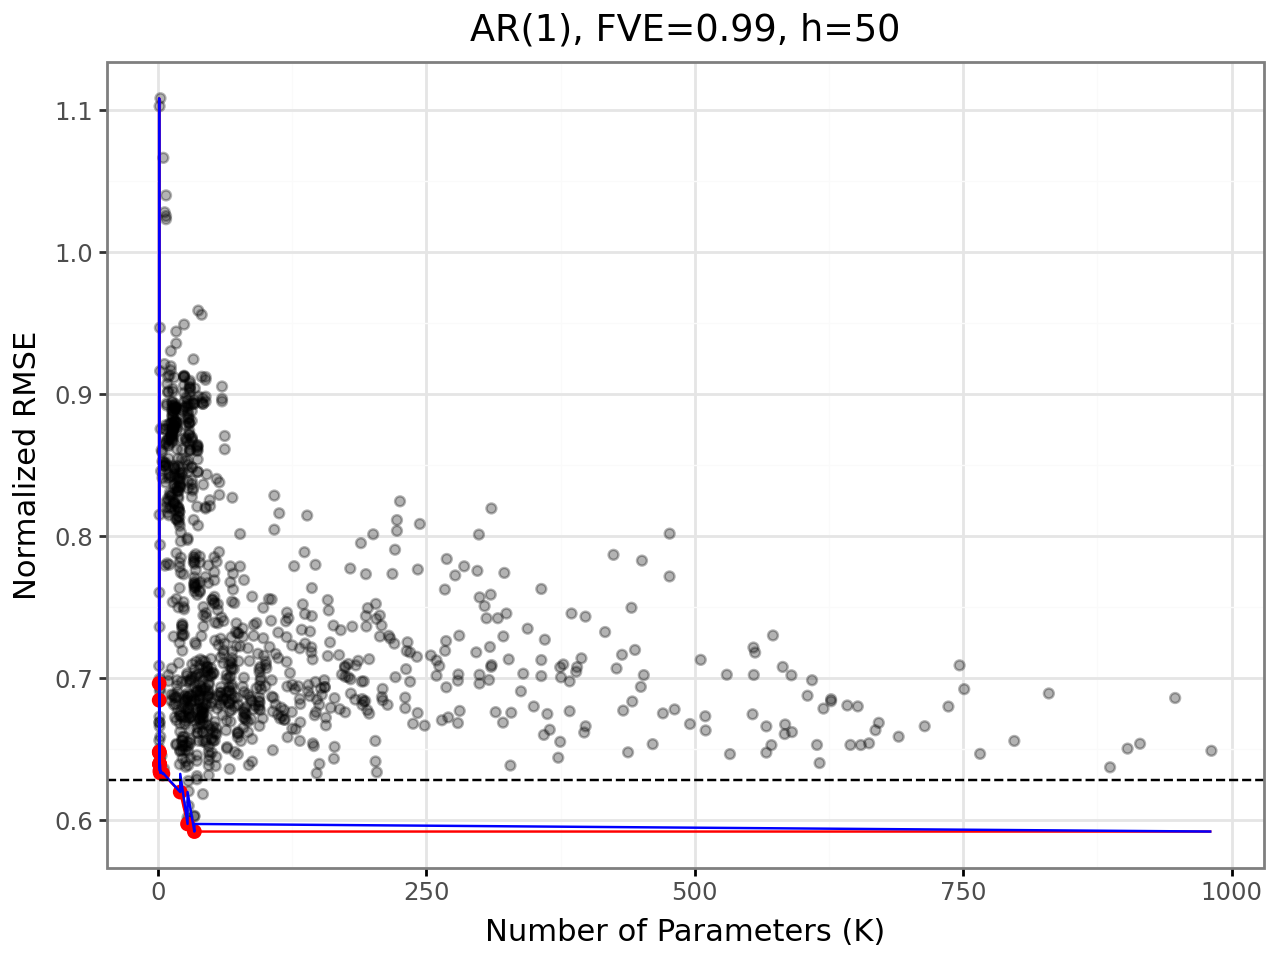

c:\ProgramData\anaconda3\envs\autogluon_env\Lib\site-packages\IPython\lib\pretty.py:794: FutureWarning: Using repr(plot) to draw and show the plot figure is deprecated and will be removed in a future version. Use plot.show().


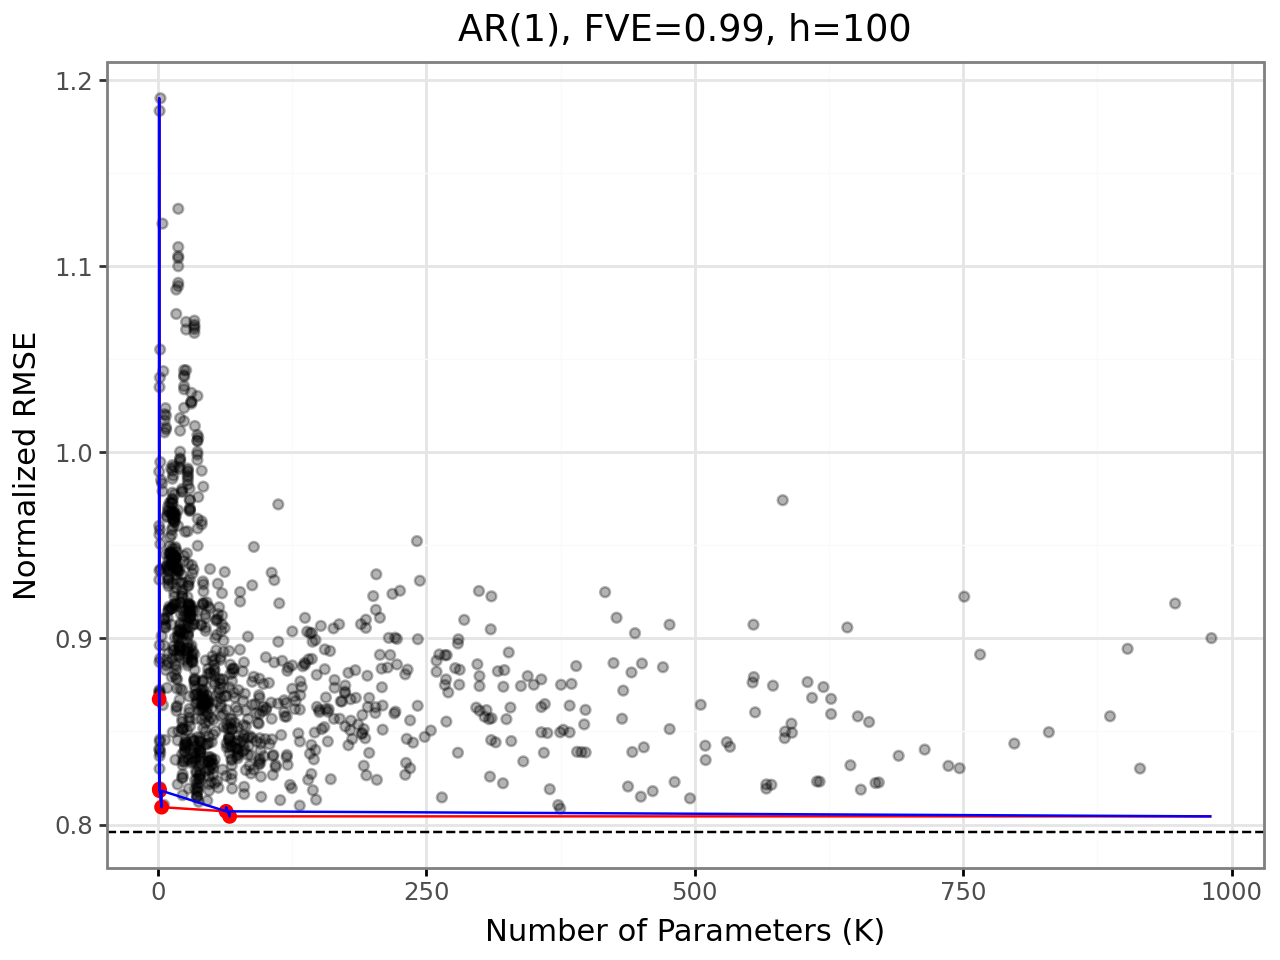

[<Figure Size: (640 x 480)>,
 <Figure Size: (640 x 480)>,
 <Figure Size: (640 x 480)>,
 <Figure Size: (640 x 480)>]

In [90]:
plots = []
for i in [1,10,50,100]:
    title = f"AR(1), FVE=0.99, h={i}"
    plot, _ = make_pareto_frontier_plot(fve_0_1_df, list([i]), "num_params", title, 0.3, False, True, 0.99)
    #save_as_pdf_pages([plot], f"{title}.pdf")
    logplot, _ = make_pareto_frontier_plot(fve_0_1_df, list([i]), "num_params", title, 0.3, True, True, 0.99)
    #save_as_pdf_pages([logplot], f"logscale{title}.pdf")
    plots.append(plot)

plots

In [143]:
def make_pareto_frontier_plot_ar1(results: pd.DataFrame, file_path: str, h: list[int], metric: str, title: str, alpha = 1,
                              log_scale: bool=False, add_oracle_NRMSE_line: bool=False, fve: float=np.nan) -> tuple[ggplot, list[int]]:

    arima_df = pd.read_parquet(f"ARIMA_model_1_{fve}_10000_100_RMSE_0.95_600_1/results.parquet")
    arima_df = arima_df[arima_df["h"].isin(h)].copy()
    arima_df = arima_df.groupby("hyper_idx").agg(
        mean_squared_error=("squared_error", "mean"),
        RMSE=("squared_error", lambda x: np.sqrt(x.mean())),
        sd = ("sd", "mean")
    )
    arima_df["normalized_rmse"] = arima_df["RMSE"] / arima_df["sd"]
    
    results = results[results["h"].isin(h)].copy()

    results = results.groupby(["hyper_idx"]).agg(
        mean_squared_error=("squared_error", "mean"),
        RMSE=("squared_error", lambda x: np.sqrt(x.mean())),
        coverage_accuracy=("coverage_flags", "mean"),
        flops = ("flops", "mean"),
        num_params = ("num_params", "mean"),
        sd = ("sd", "mean")
    )

    results["normalized_rmse"] = results["RMSE"] / results["sd"]
    if metric == "flops":
        xlab = "Flops (K)"
    else:
        xlab = "Number of Parameters (K)"

    results.reset_index(drop=False, inplace=True)
    pareto_hyper_idx, x_b, y_b, x_eb, y_eb= find_pareto_front_hyperidx(results[metric].values, results["normalized_rmse"].values)
    results["boundary_flags"] = results["hyper_idx"].isin(pareto_hyper_idx)
    
    boundary_df = pd.DataFrame({metric: x_b, "normalized_rmse": y_b})
    enhanced_boundary_df = pd.DataFrame({metric: x_eb[:-1], "normalized_rmse": y_eb[:-1],
                                         "metric_end": x_eb[1:], "normalized_rmse_end": y_eb[1:]})

    plot = (
        ggplot(results, aes(x = metric, y = "normalized_rmse")) +
        geom_point(alpha = alpha) +
        geom_segment(aes(x = metric, y = "normalized_rmse", xend = "metric_end", yend = "normalized_rmse_end"),
                     data = enhanced_boundary_df, color = "red") +
        geom_point(results[results["boundary_flags"]], color = "blue", size = 2) + 
        geom_hline(yintercept = arima_df["normalized_rmse"], linetype = "dotted") +
        # geom_line(boundary_df, aes(x = metric, y = "normalized_rmse"), color = "red") + 
        # geom_line(enhanced_boundary_df, aes(x = metric, y = "normalized_rmse"), color = "blue") +
        labs(x = xlab, y = "Normalized RMSE", title=title) +
        theme_bw()
    )

    

    if log_scale:
        plot = plot + scale_x_log10()

    if add_oracle_NRMSE_line:
        plot = plot + geom_hline(yintercept = np.sqrt(1-fve**min(h)), linetype = "dashed")
    boundary_idx = []
    
    print((arima_df["normalized_rmse"].values, np.sqrt(1-fve**min(h))))
    return plot, boundary_idx

(array([0.30956708]), 0.30922148209850425)


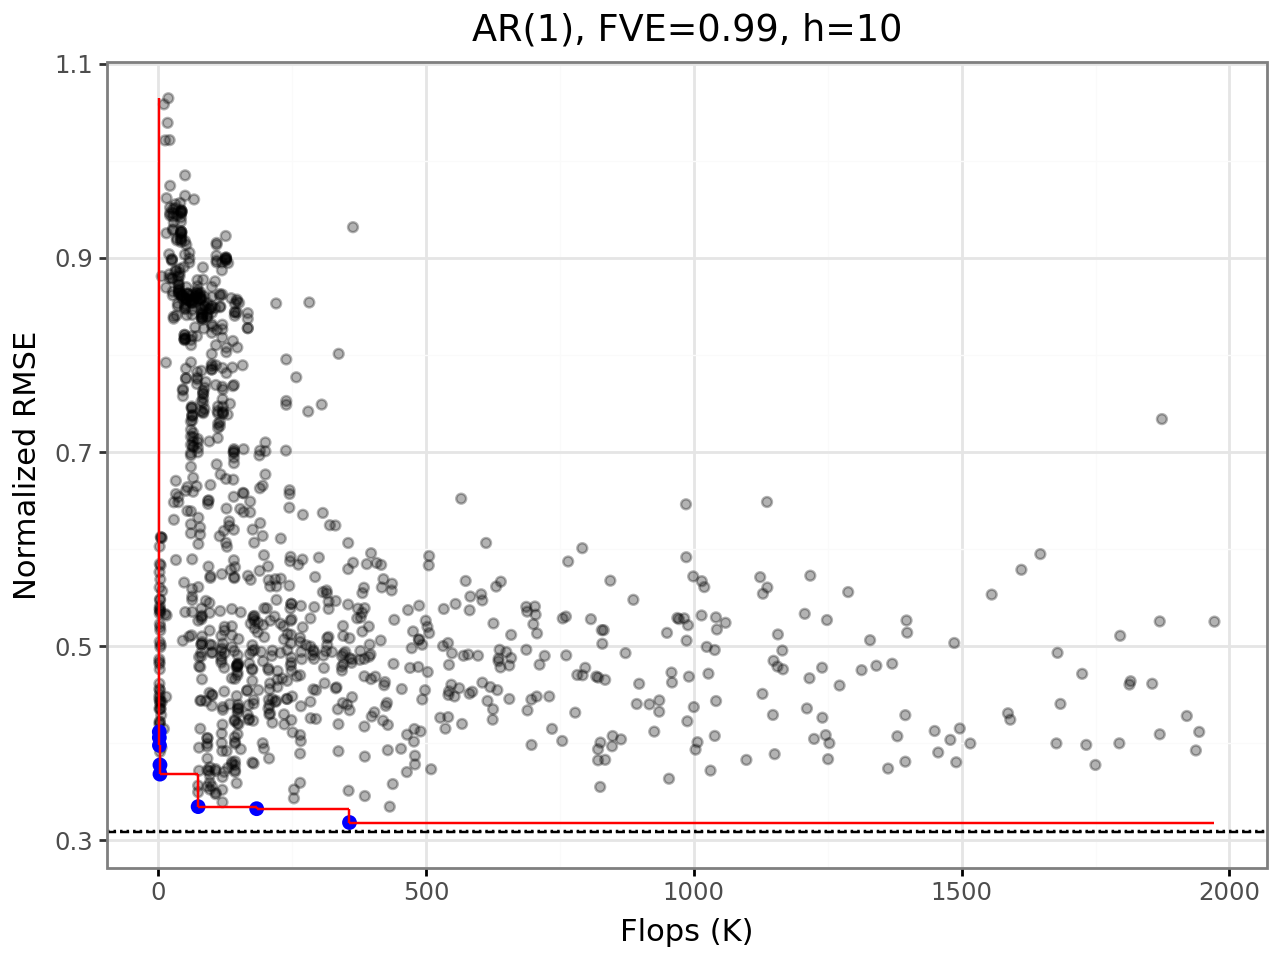

In [133]:
title = "AR(1), FVE=0.99, h=10"
plot, _= make_pareto_frontier_plot_ar1(fve_0_1_df, "",list([10]), "flops", title, 0.3, False, True, 0.99)
plot


In [ ]:
plots = []
for i in [1,10,50,100]:
    title = f"AR(1), FVE=0.99, h={i}"
    plot, _ = make_pareto_frontier_plot(fve_0_1_df, list([i]), "flops", title, 0.3, False, True, 0.99)
    #save_as_pdf_pages([plot], f"{title}.pdf")
    logplot, _ = make_pareto_frontier_plot(fve_0_1_df, list([i]), "flops", title, 0.3, True, True, 0.99)
    #save_as_pdf_pages([logplot], f"logscale{title}.pdf")
    plots.append(plot)

plots

In [137]:
import glob
files = glob.glob("../Xray_Flux/multi_model_1000_0.1_10000_100_RMSE_0.95_600_1/*.parquet")

In [140]:
pd.read_parquet("../Xray_Flux/multi_model_1000_0.1_10000_100_RMSE_0.95_600_1/results.parquet")

,hyper_idx,h,observed,prediction,lower_bound,upper_bound,coverage_flags,squared_error,pred_length,flops,num_params,sd,runtime
0,876,1,4.842857e-07,5.042762e-07,2.870283e-07,7.215241e-07,True,3.996187e-16,4.344959e-07,197.48,46.50,3.312755e-07,PatchTST
1,876,2,4.785715e-07,5.044211e-07,2.692921e-07,7.395503e-07,True,6.682048e-16,4.702582e-07,197.48,46.50,3.312755e-07,PatchTST
2,876,3,4.771429e-07,5.164213e-07,2.870329e-07,7.458098e-07,True,1.542798e-15,4.587769e-07,197.48,46.50,3.312755e-07,PatchTST
3,876,4,4.714286e-07,5.230356e-07,2.046949e-07,8.413766e-07,True,2.663286e-15,6.366816e-07,197.48,46.50,3.312755e-07,PatchTST
4,876,5,4.671429e-07,4.980469e-07,2.040364e-07,7.920575e-07,True,9.550557e-16,5.880212e-07,197.48,46.50,3.312755e-07,PatchTST
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1239995,999,96,1.207143e-06,1.201095e-06,1.616263e-07,2.240563e-06,True,3.658275e-17,2.078937e-06,357.30,111.65,3.312755e-07,PatchTST
1239996,999,97,1.185714e-06,1.250161e-06,3.560725e-07,2.144250e-06,True,4.153360e-15,1.788177e-06,357.30,111.65,3.312755e-07,PatchTST
1239997,999,98,1.167143e-06,1.221594e-06,3.164517e-07,2.126736e-06,True,2.964911e-15,1.810285e-06,357.30,111.65,3.312755e-07,PatchTST
1239998,999,99,1.150000e-06,1.230020e-06,2.500067e-07,2.210033e-06,True,6.403157e-15,1.960027e-06,357.30,111.65,3.312755e-07,PatchTST


In [139]:
data = pd.concat((pd.read_parquet(f) for f in files[1:]))
print(len(data))
data.head()

10000000


,hyper_idx,h,observed,prediction,lower_bound,upper_bound,coverage_flags,squared_error,pred_length,flops,num_params,sd,runtime
0,0,1,4.842857e-07,5.026523e-07,1.349996e-07,8.703053e-07,True,3.373327e-16,7.353057e-07,149.28,40.39,3.312755e-07,PatchTST
1,0,2,4.785715e-07,5.107923e-07,5.074999e-08,9.708348e-07,True,1.038182e-15,9.200848e-07,149.28,40.39,3.312755e-07,PatchTST
2,0,3,4.771429e-07,5.054055e-07,9.693378e-08,9.138773e-07,True,7.987748e-16,8.169436e-07,149.28,40.39,3.312755e-07,PatchTST
3,0,4,4.714286e-07,5.088919e-07,2.450149e-07,7.727690e-07,True,1.403500e-15,5.277541e-07,149.28,40.39,3.312755e-07,PatchTST
4,0,5,4.671429e-07,5.285291e-07,1.178679e-07,9.391904e-07,True,3.768266e-15,8.213225e-07,149.28,40.39,3.312755e-07,PatchTST


c:\ProgramData\anaconda3\envs\autogluon_env\Lib\site-packages\plotnine\layer.py:364: PlotnineWarning: geom_hline : Removed 1 rows containing missing values.


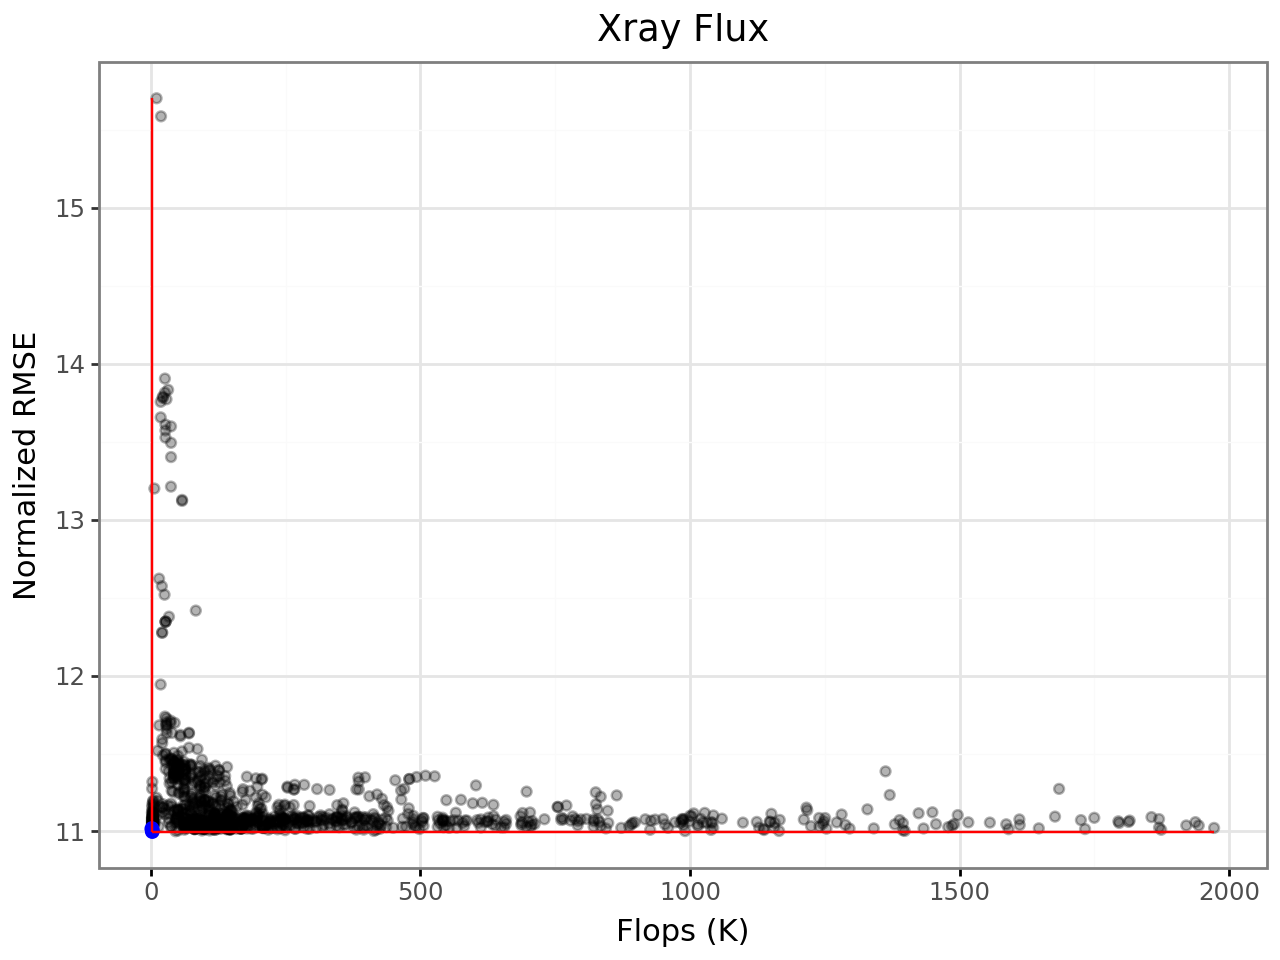

In [142]:
title = "Xray Flux"
plot, _= make_pareto_frontier_plot(data,list(range(51,64)), "flops", title, 0.3, False, True)
plot